- Use dynamic functional connectivity
- Find correlation between ROIs based on cc400 atlas, using a sliding time window approach
- window size will be 22 Time points , step size 1 Time point `https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6549695/`
- Pearson's correlation coefficent will be used to compute a matrix,
- this matrix will be the iput for CNN

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8514188/ suggests using a window size of 50TR or 100s
-https://onlinelibrary.wiley.com/doi/full/10.1002/brb3.1255 suggests a window size of at least 120s 60TR

## Network choices

- CNN
- Reccurrent Convolution neural network, utilising LSTM layer to capture sequential data. (https://www.frontiersin.org/articles/10.3389/fnins.2022.933660/full)


In [2]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from dfc_functions import PickPickle
import pickle

In [64]:
parent_dir = os.path.dirname(os.getcwd()) # get parent directory
pheno_dir = os.path.join(parent_dir, 'phenotype_files') # get directory for phenotype data files
phenotype_path = os.path.join(parent_dir,'phenotype_files/pheno_clean.csv') # path to phenotype file

In [65]:
df = pd.read_csv(phenotype_path) # load the phenotype data

In [66]:
df.head()

,SUB_ID,FILE_ID,AGE_AT_SCAN,SEX,DSM_IV_TR,DX_GROUP,FMRI_FILES,CC200,DFC_DATA_STORE
0,50002,Pitt_0050002,16.77,1,1,1,Pitt_0050002_func_preproc.nii.gz,Pitt_0050002_rois_cc200.1D,Pitt_0050002_dfc.pkl
1,50003,Pitt_0050003,24.45,1,1,1,Pitt_0050003_func_preproc.nii.gz,Pitt_0050003_rois_cc200.1D,Pitt_0050003_dfc.pkl
2,50004,Pitt_0050004,19.09,1,1,1,Pitt_0050004_func_preproc.nii.gz,Pitt_0050004_rois_cc200.1D,Pitt_0050004_dfc.pkl
3,50005,Pitt_0050005,13.73,2,1,1,Pitt_0050005_func_preproc.nii.gz,Pitt_0050005_rois_cc200.1D,Pitt_0050005_dfc.pkl
4,50006,Pitt_0050006,13.37,1,1,1,Pitt_0050006_func_preproc.nii.gz,Pitt_0050006_rois_cc200.1D,Pitt_0050006_dfc.pkl


In [108]:
class FetchROI:
    """
    load ROI time series data
    """
    def __init__(self, roi_path):
        """
        iniatialise object
        :param roi_path: full file path to roi timeseries data
        """
        self.roi_dir = roi_path

    def fetch_roi_avg_ts(self, roi_file):
        """
        :param roi_file: specific time series  data file name
        :return:
        """
        roi_path = os.path.join(self.roi_dir,roi_file) # path to time series data
        output = pd.read_csv(roi_path, sep='\t', lineterminator='\n') # load tap seperated file as pandas dataframe
        return output

In [109]:
"""
plotting roi timeseries data
"""
def plot_roi(data,roi1,roi2):
    """

    :param data: roi dataframe
    :param roi1: roi number
    :param roi2:roi number
    :return:
    """
    plt.figure(figsize= (10,5))
    plt.plot(data.iloc[:,roi1-1]) # plot 1st roi timeseries due to 0 indexing minus roi number by 1
    plt.plot(data.iloc[:,roi2-1])
    plt.xlabel("time point")
    plt.ylabel("Signal level")
    plt.title(f"ROI #{roi1} & #{roi2} ")
    plt.legend((f"#{roi1}",f"#{roi2}"))
    plt.show()

In [49]:
cc200_files = df.loc[:,'CC200'] # all roi timeseries filenames

In [111]:
cc200_dir= os.path.join(parent_dir,'rois_cc200') # subdirectory for roi timeseries data

In [112]:
cc200_paths = []# all paths to roi data
for i in range(len(cc200_files)):
    x = os.path.join(cc200_dir, cc200_files[i])
    cc200_paths.append(x)

In [113]:
test = cc200_paths[1]

In [114]:
roi_loader = FetchROI(cc200_dir) # initialize FetchROI object

In [115]:
t_df_1 = roi_loader.fetch_roi_avg_ts(cc200_paths[1]) # load timeseries data

In [116]:
t_df_1.head()

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,#191,#192,#193,#194,#195,#196,#197,#198,#199,#200\r
0,-5.850851,-33.937427,-6.593561,1.333683,-3.698016,0.592722,-50.439077,-2.394552,8.105984,26.163370,...,10.112506,1.425284,3.484113,-48.883223,-3.897863,25.631350,0.077750,-3.667082,-39.567115,-35.527189
1,-12.692127,-37.055576,-4.489373,-7.471347,-6.855605,-3.209540,-52.261003,-2.783127,9.802492,15.007663,...,13.751808,0.940839,4.551117,-84.822505,13.468059,31.632908,-3.341145,-2.019567,-37.707013,-37.962079
2,-15.948725,-26.821254,4.347373,-16.772396,-9.954731,-13.535967,-42.782575,-0.446070,6.968022,-4.154753,...,11.433119,0.714730,3.821768,-103.664102,37.326197,25.211417,-5.920993,1.148628,-17.806549,-29.741453
3,-14.823152,-6.256209,19.428696,-21.770798,-10.553262,-25.041902,-25.792101,3.493502,-0.717598,-22.773228,...,3.863746,-0.536322,1.230057,-94.159728,51.761831,7.071710,-4.769585,4.657836,12.096809,-15.296542
4,-13.247481,16.314632,37.109767,-19.865811,-6.679464,-29.008077,-6.244157,5.886405,-9.504406,-32.578009,...,-4.671372,-2.367938,-2.566303,-56.179140,43.125796,-15.906330,2.579416,7.196374,37.939104,-0.518543


In [41]:
"""
plotting roi timeseries data
"""
def plot_roi(data,roi1,roi2):
    """

    :param data: roi dataframe
    :param roi1: roi number
    :param roi2:roi number
    :return:
    """
    plt.figure(figsize= (10,5))
    plt.plot(data.iloc[:,roi1-1]) # plot 1st roi timeseries due to 0 indexing minus roi number by 1
    plt.plot(data.iloc[:,roi2-1])
    plt.xlabel("time point")
    plt.ylabel("Signal level")
    plt.title(f"ROI #{roi1} & #{roi2} ")
    plt.legend((f"#{roi1}",f"#{roi2}"))
    plt.show()

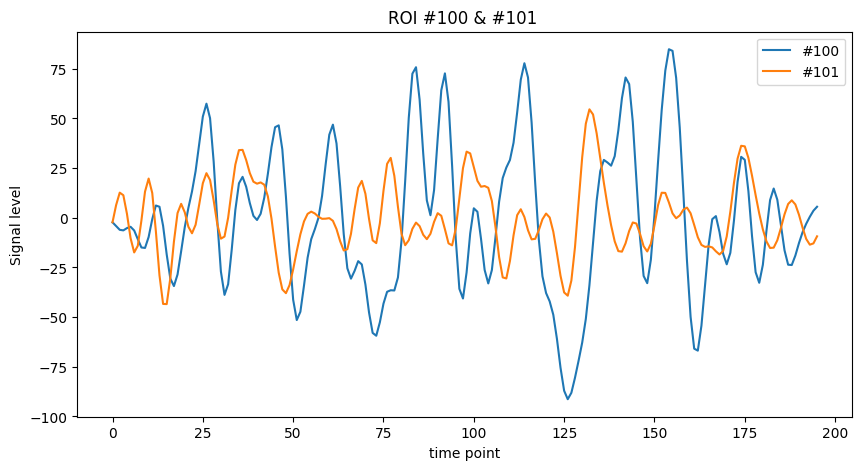

In [130]:
plot_roi(t_df_1,100,101)

In [47]:
corrs =t_df_1.corr(method = 'pearson')

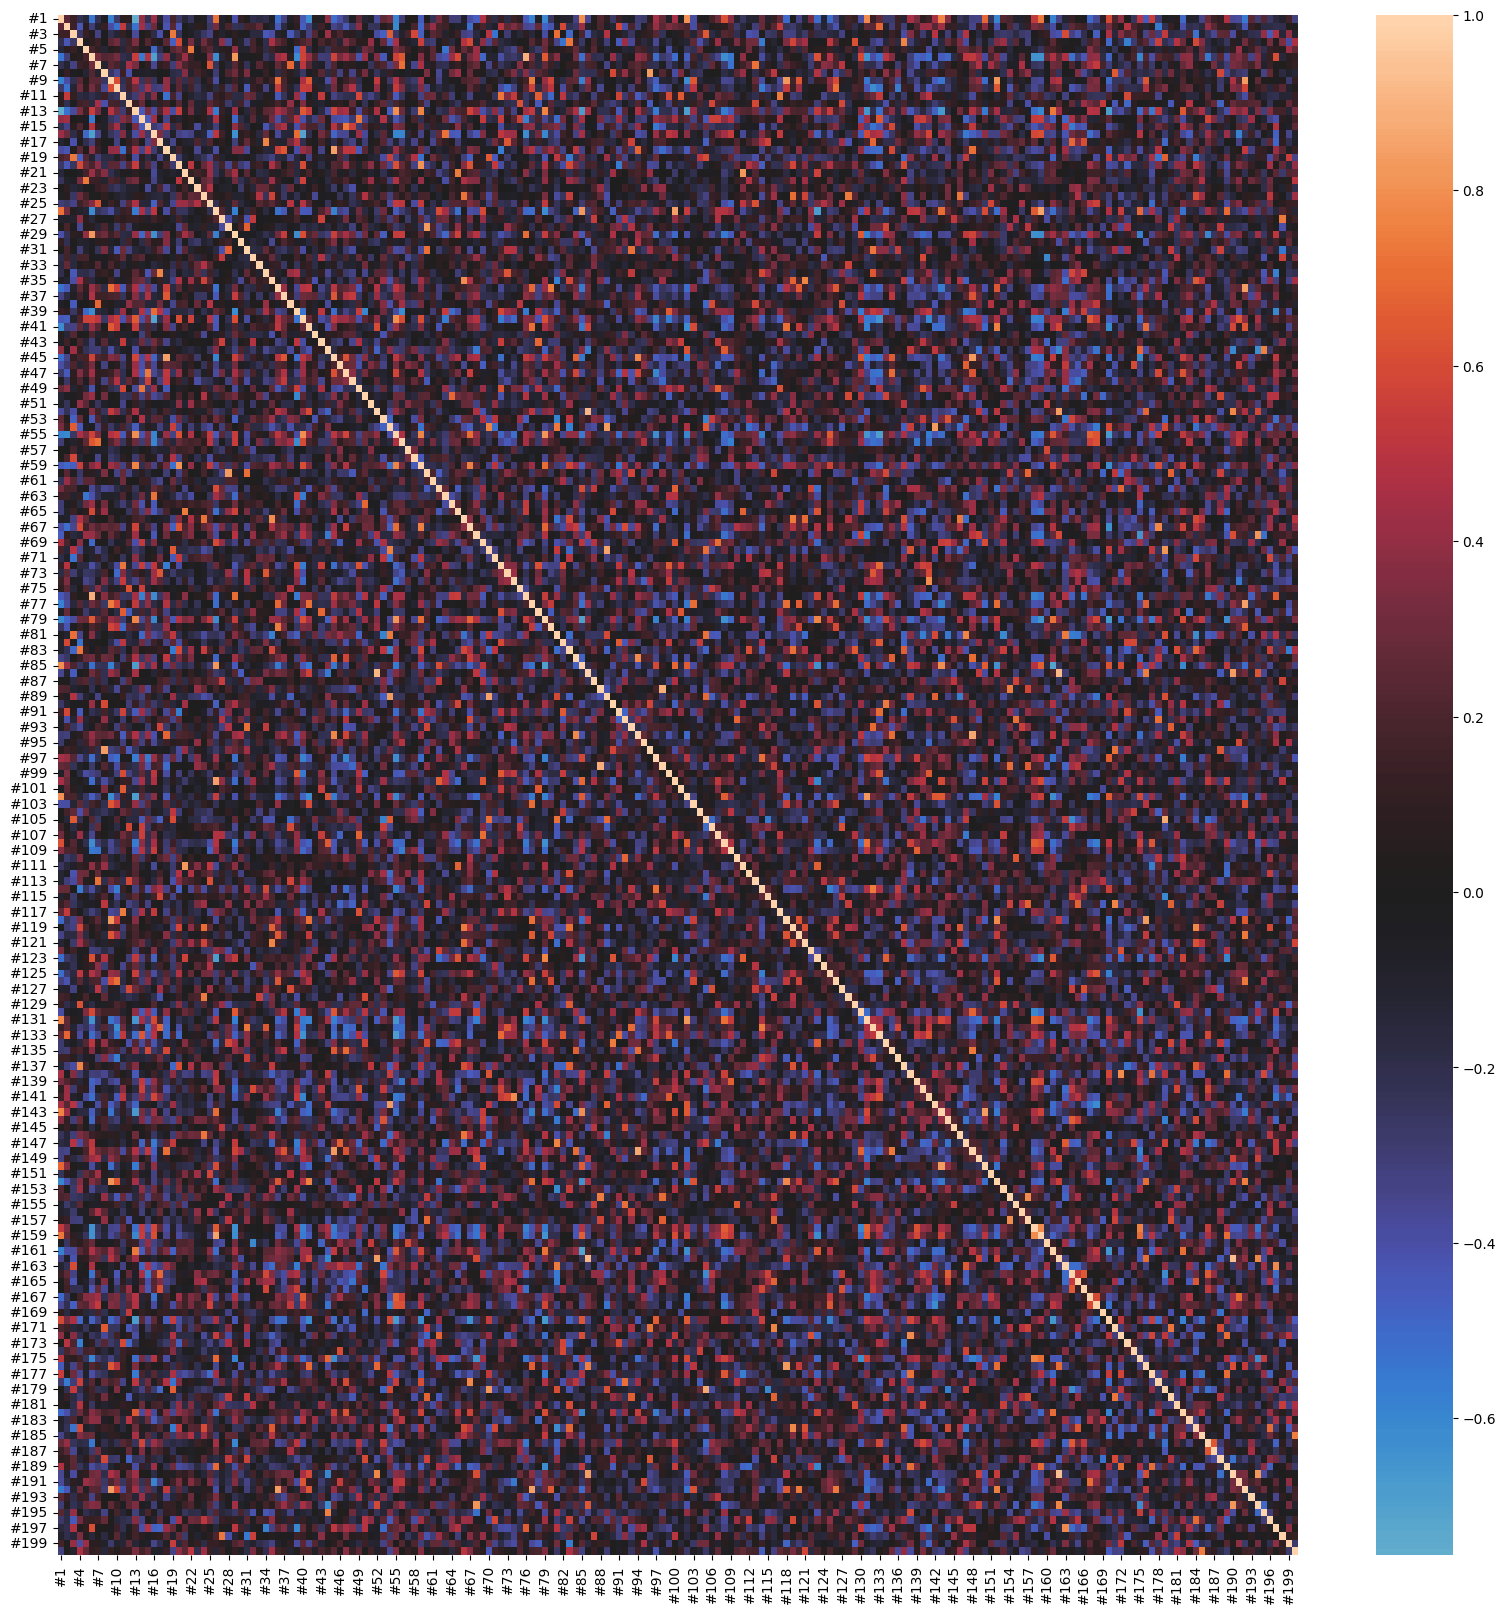

In [131]:
plt.figure(figsize= (20,20))
sns.heatmap(corrs, annot=False, center = 0)
plt.show()

## Dynamic functional correlation (dFC)

number of time points to be used is 116
- first 5 will be removed as advised by literature
- therefore 111 timepoints available for analysis.
- 90 temporal windows available (111-22 +1)



In [133]:
t_df_1

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,#191,#192,#193,#194,#195,#196,#197,#198,#199,#200\r
0,-5.850851,-33.937427,-6.593561,1.333683,-3.698016,0.592722,-50.439077,-2.394552,8.105984,26.163370,...,10.112506,1.425284,3.484113,-48.883223,-3.897863,25.631350,0.077750,-3.667082,-39.567115,-35.527189
1,-12.692127,-37.055576,-4.489373,-7.471347,-6.855605,-3.209540,-52.261003,-2.783127,9.802492,15.007663,...,13.751808,0.940839,4.551117,-84.822505,13.468059,31.632908,-3.341145,-2.019567,-37.707013,-37.962079
2,-15.948725,-26.821254,4.347373,-16.772396,-9.954731,-13.535967,-42.782575,-0.446070,6.968022,-4.154753,...,11.433119,0.714730,3.821768,-103.664102,37.326197,25.211417,-5.920993,1.148628,-17.806549,-29.741453
3,-14.823152,-6.256209,19.428696,-21.770798,-10.553262,-25.041902,-25.792101,3.493502,-0.717598,-22.773228,...,3.863746,-0.536322,1.230057,-94.159728,51.761831,7.071710,-4.769585,4.657836,12.096809,-15.296542
4,-13.247481,16.314632,37.109767,-19.865811,-6.679464,-29.008077,-6.244157,5.886405,-9.504406,-32.578009,...,-4.671372,-2.367938,-2.566303,-56.179140,43.125796,-15.906330,2.579416,7.196374,37.939104,-0.518543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,9.719535,1.105157,-1.070748,13.549850,-3.001756,-17.216719,-3.660573,-3.256201,35.722208,21.159171,...,-3.294938,17.895666,19.094149,-21.956568,-7.379666,5.504797,-35.153606,-10.087921,-51.685032,14.320956
192,2.598058,7.791873,-4.592978,11.511701,-4.763378,-22.787673,-32.406541,5.263596,24.231866,13.432634,...,-11.411607,7.637142,6.206620,-22.495466,-25.901625,-1.114449,-38.117601,-11.005657,-54.787973,0.969334
193,-7.720936,7.120426,-10.199512,5.011554,-6.194441,-19.681634,-50.468281,14.868030,5.575044,6.298557,...,-14.436297,-2.017352,-7.166686,-17.411733,-30.295568,-4.568798,-32.016273,-9.741099,-43.670518,-16.795009
194,-13.752676,-0.360954,-17.188173,-0.807427,-6.639072,-10.532353,-51.433218,22.138011,-12.480794,1.714401,...,-12.665388,-8.708578,-14.385268,-10.903991,-22.519627,-0.995396,-19.783623,-5.759258,-25.512161,-29.552690


#### calculating dFC time window 22

In [134]:
dFC1 = {} # store dFC data in dictionary, with time window number as key and correlation matrix as value
for i in range(len(t_df_1)):
    if (i + 22) <= len(t_df_1):# to stop rolling window from exceeding timepoints
        dFC1[i+1]= t_df_1.iloc[i:i+22].corr(method= 'pearson')# find correlation within a 22 point window
    else: #if window exceeds length of timeseries break operation
        break


In [139]:
dFC1

{1:               #1        #2        #3        #4        #5        #6        #7  \
 #1      1.000000 -0.291985 -0.803563  0.550760 -0.338823 -0.340389  0.230491   
 #2     -0.291985  1.000000  0.547009 -0.112546  0.217440 -0.108742  0.373939   
 #3     -0.803563  0.547009  1.000000 -0.476645  0.197991 -0.025521 -0.059362   
 #4      0.550760 -0.112546 -0.476645  1.000000  0.333085  0.337593  0.307806   
 #5     -0.338823  0.217440  0.197991  0.333085  1.000000  0.742671 -0.224030   
 ...          ...       ...       ...       ...       ...       ...       ...   
 #196    0.566731 -0.506089 -0.569943  0.285558 -0.667332 -0.413754  0.216379   
 #197   -0.714079  0.068721  0.668575 -0.200663  0.374550  0.560334  0.111943   
 #198   -0.511845  0.111009  0.590517 -0.271105  0.583062  0.093683 -0.678276   
 #199   -0.087776  0.207112  0.229166 -0.057999  0.652819  0.213054 -0.347453   
 #200\r -0.392416  0.687648  0.440054 -0.035491  0.462288  0.473252  0.556996   
 
               #8      

Best to store the dFC dictionary as pickle file with filename having a unique identifier containing FILE_ID

Adopt above operation, and automate process for all timeseries data.
The functions for calculatinf DFC will be stored in dfc_functions

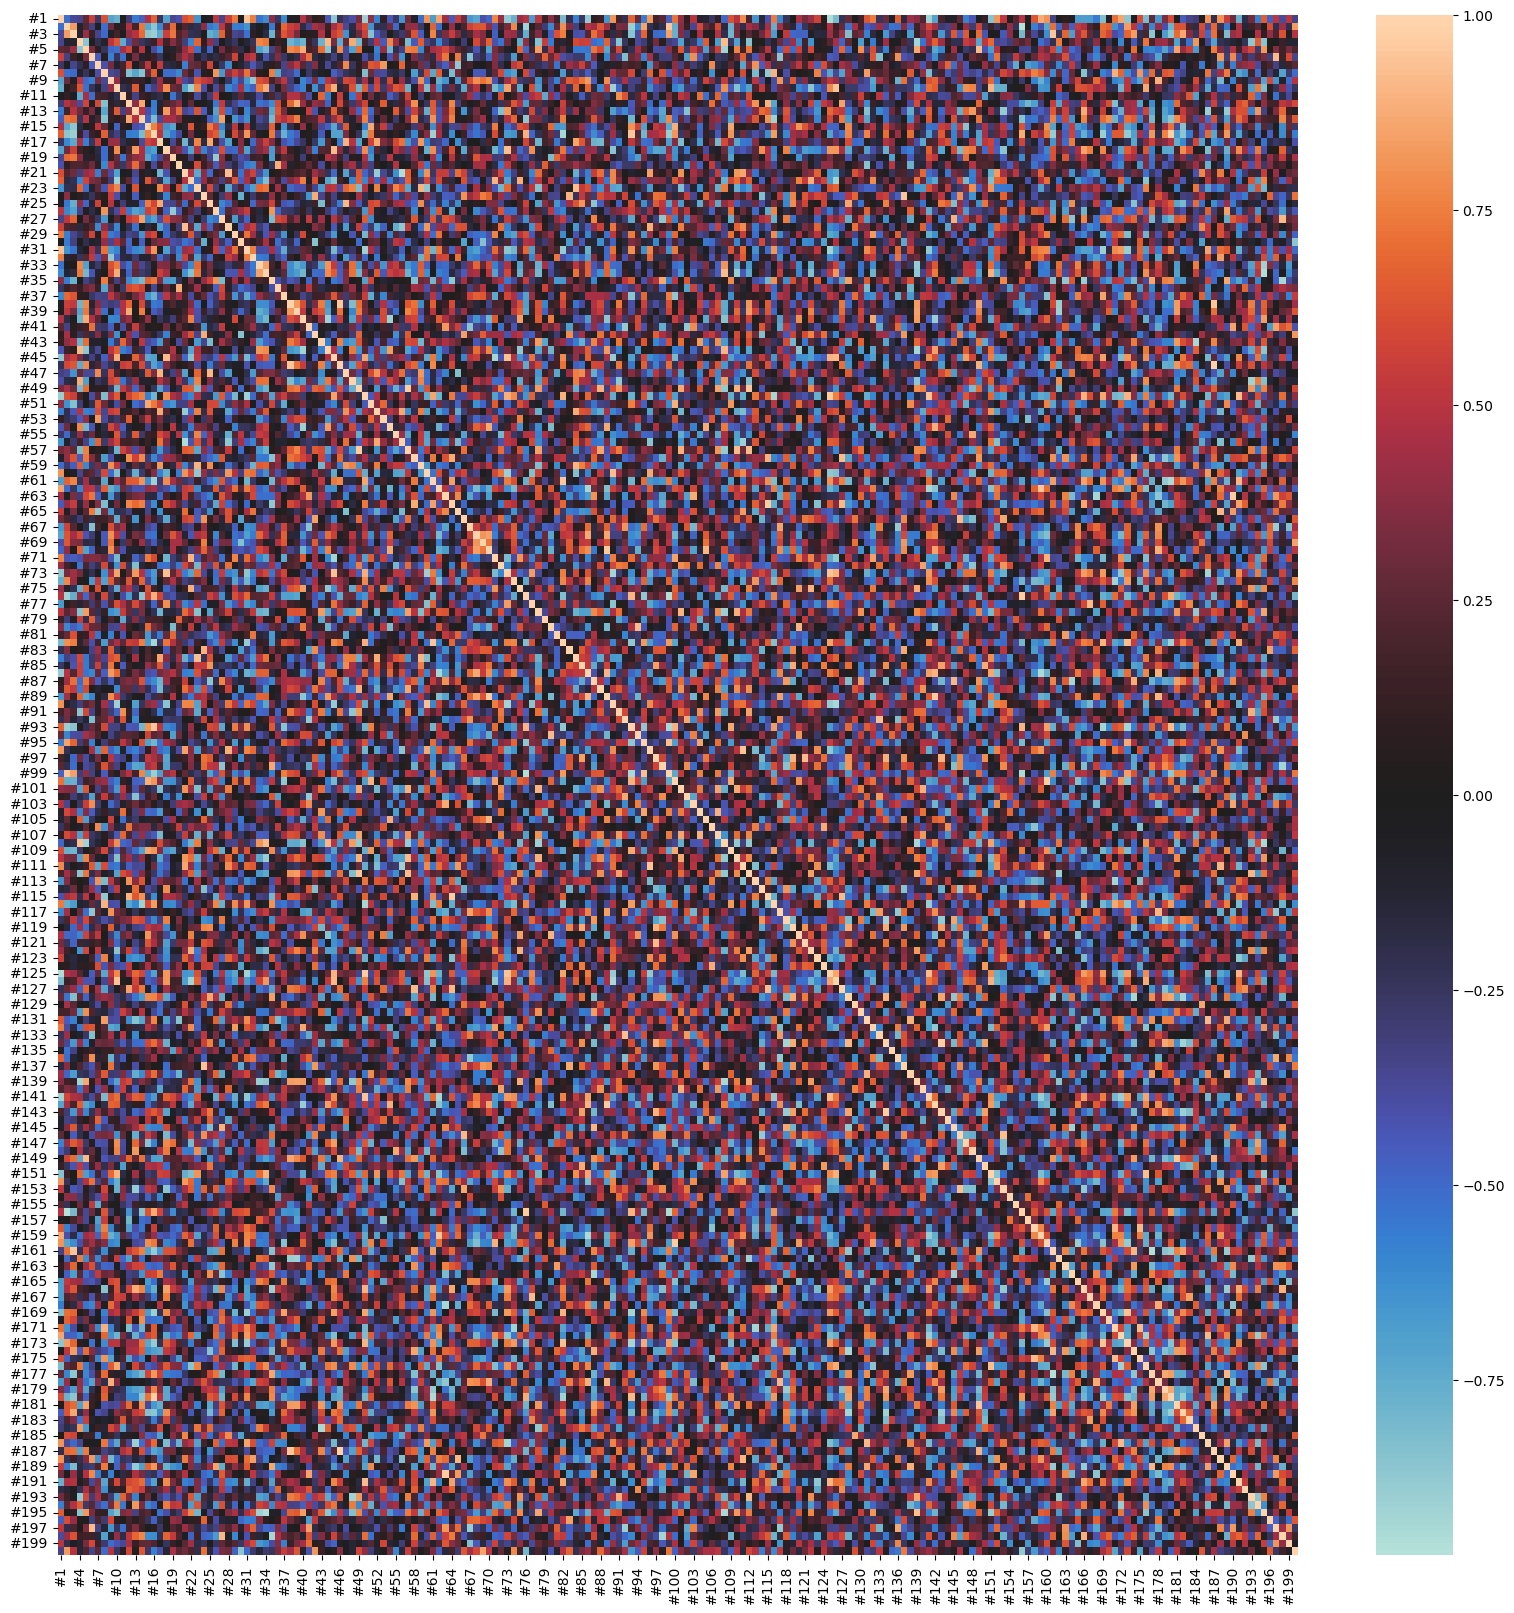

In [325]:
"""
display heatmap of one time window of correlation values
"""
plt.figure(figsize= (20,20))
sns.heatmap(dFC1[90], annot=False, center = 0)
plt.show()

## calculate dfc time window 70

In [132]:
d_check = t_df_1.iloc[5:116, :]

In [133]:
dFC2 = {} # store dFC data in dictionary, with time window number as key and correlation matrix as value
for i in range(len(d_check)):
    if (i + 70) <= len(d_check):# to stop rolling window from exceeding timepoints
        dFC2[i+1]= d_check.iloc[i:i+70].corr(method= 'pearson')# find correlation within a 22 point window
    else: #if window exceeds length of timeseries break operation
        break


In [134]:
len(dFC2)

42

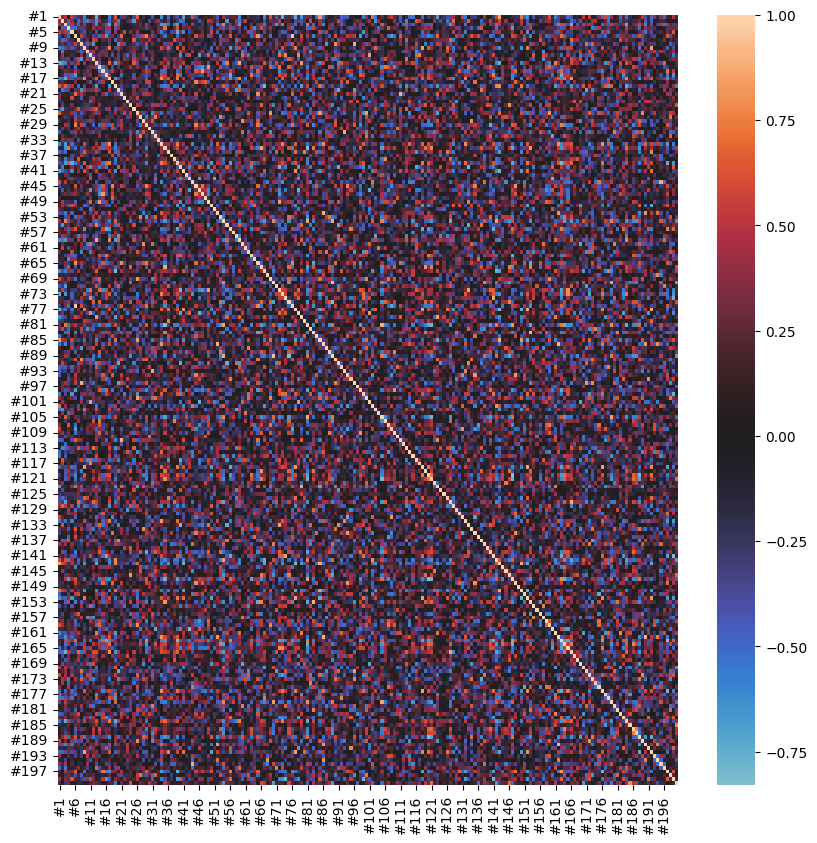

In [129]:
plt.figure(figsize= (10,10))
sns.heatmap(dFC2[90], annot=False, center = 0)
plt.show()

## Exploring dFC data in pickle files

Import PickPickle from dfc_functions package for loading pickle data

In [67]:
from dfc_functions import PickPickle

In [68]:
pickle_dir = os.path.join(parent_dir, 'dfc_cc200') # subdirectory containing dfc data

In [19]:
pheno_df = pd.read_csv(phenotype_path)
pheno_df.head()

,SUB_ID,FILE_ID,AGE_AT_SCAN,SEX,DSM_IV_TR,DX_GROUP,FMRI_FILES,CC200,DFC_DATA_STORE
0,50002,Pitt_0050002,16.77,1,1,1,Pitt_0050002_func_preproc.nii.gz,Pitt_0050002_rois_cc200.1D,Pitt_0050002_dfc.pkl
1,50003,Pitt_0050003,24.45,1,1,1,Pitt_0050003_func_preproc.nii.gz,Pitt_0050003_rois_cc200.1D,Pitt_0050003_dfc.pkl
2,50004,Pitt_0050004,19.09,1,1,1,Pitt_0050004_func_preproc.nii.gz,Pitt_0050004_rois_cc200.1D,Pitt_0050004_dfc.pkl
3,50005,Pitt_0050005,13.73,2,1,1,Pitt_0050005_func_preproc.nii.gz,Pitt_0050005_rois_cc200.1D,Pitt_0050005_dfc.pkl
4,50006,Pitt_0050006,13.37,1,1,1,Pitt_0050006_func_preproc.nii.gz,Pitt_0050006_rois_cc200.1D,Pitt_0050006_dfc.pkl


In [20]:
all_dfc =pheno_df.loc[:,'DFC_DATA_STORE']

In [21]:
loader = PickPickle(pickle_dir) # initialise object with pickle directory

A cursory glance at the dFC data revealed that there a Nan values in subjects in the Caltech group

In [22]:
test1 = loader.get_pickle('Caltech_0051457_dfc.pkl') # import pkl file where missing values were noticed

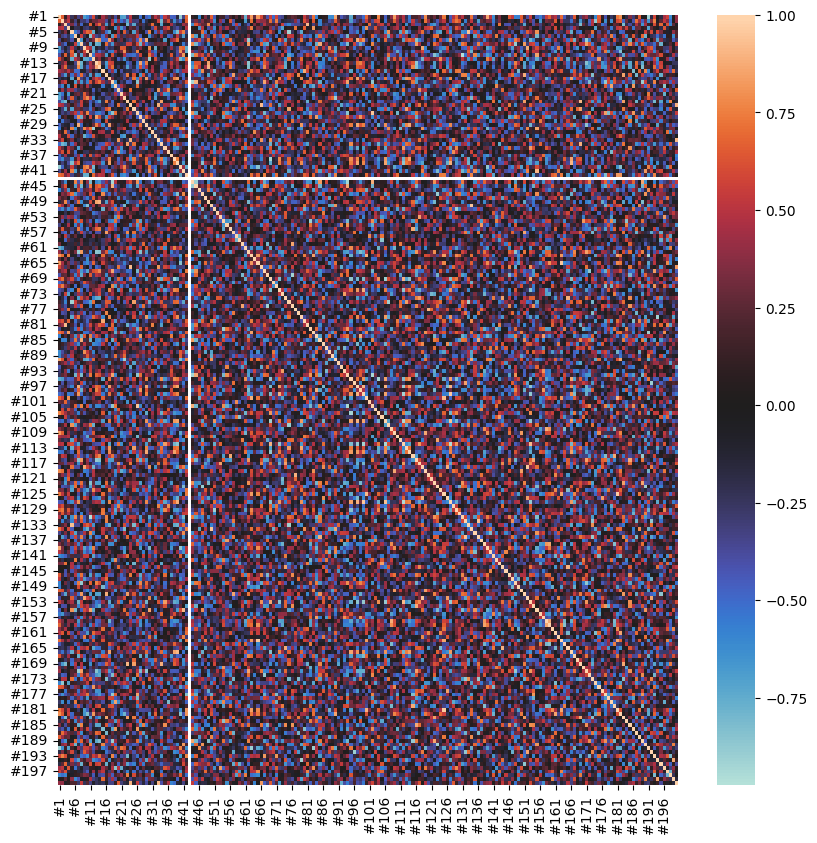

In [23]:
plt.figure(figsize= (10,10))
sns.heatmap(test1[1], annot=False, center = 0)
plt.show()

The blank lines indicate missing values in correlation data, manually searching in random time windows show all time windows contain null values in the same ROI

In [24]:
test1[1]

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,#191,#192,#193,#194,#195,#196,#197,#198,#199,#200\r
#1,1.000000,0.662670,0.111636,0.470901,-0.243268,0.161316,-0.334941,0.307558,-0.682527,-0.585882,...,-0.912305,-0.181189,0.573931,-0.000747,-0.178829,0.451647,0.558132,-0.609979,0.040773,0.401837
#2,0.662670,1.000000,0.324870,0.521496,0.149927,-0.316094,0.072709,-0.307954,-0.284976,-0.402976,...,-0.641611,0.349054,0.756720,-0.074570,0.246806,0.520339,0.363569,-0.518961,0.059525,0.391722
#3,0.111636,0.324870,1.000000,-0.319372,0.347792,-0.391693,0.188241,-0.483069,-0.106011,-0.148812,...,0.142683,-0.061890,0.602472,0.132608,0.684826,-0.114261,0.610061,-0.599740,0.252739,-0.060875
#4,0.470901,0.521496,-0.319372,1.000000,0.031275,-0.231168,-0.212722,0.045065,-0.263121,-0.299803,...,-0.704999,0.253364,0.090909,-0.034318,-0.194273,0.633317,-0.172736,0.050957,0.052306,0.080488
#5,-0.243268,0.149927,0.347792,0.031275,1.000000,-0.556148,-0.395855,-0.130836,0.492810,0.689091,...,0.185483,0.586312,-0.114412,0.574736,0.343579,0.102624,-0.097810,-0.073150,0.392930,0.209496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#196,0.451647,0.520339,-0.114261,0.633317,0.102624,-0.526896,-0.223227,-0.069464,-0.283595,-0.298967,...,-0.675625,0.101963,0.414237,0.248928,-0.216092,1.000000,-0.098104,-0.317184,0.394755,0.050661
#197,0.558132,0.363569,0.610061,-0.172736,-0.097810,0.083635,-0.154026,-0.139021,-0.307981,-0.443635,...,-0.340443,-0.234909,0.651077,0.119600,0.443229,-0.098104,1.000000,-0.781514,0.269686,-0.086699
#198,-0.609979,-0.518961,-0.599740,0.050957,-0.073150,0.101434,0.131003,0.233140,0.367380,0.327895,...,0.418257,0.001028,-0.818198,-0.064508,-0.481708,-0.317184,-0.781514,1.000000,-0.238268,0.010081
#199,0.040773,0.059525,0.252739,0.052306,0.392930,-0.624813,-0.441261,-0.058037,-0.071409,0.078957,...,-0.194703,-0.254868,0.174237,0.865091,0.095692,0.394755,0.269686,-0.238268,1.000000,-0.153379


In [25]:
rois = test1[1].columns.to_list()

In [26]:
test1[1].loc[:,rois[1]].isnull().sum() # there is one region with a Nan values

1

In [27]:
null_one = [] # roi column with 1 missing value
null_more = []# roi column with more than 1 missing value
for i,roi in enumerate(rois):
    null_num = test1[1].loc[:,rois[i]].isnull().sum()
    if null_num == 1:
        null_one.append(roi)
    else:
        null_more.append(roi)

In [28]:
print(len(null_one), len(null_more)) # there is one ROI with more than 1 missing value this must be the roi with missing values

199 1


In [29]:
null_more # roi with all missing values in time window 1

['#43']

In [30]:
pheno_df[pheno_df['FILE_ID']== 'Caltech_0051457'] # get all data on this subject

,SUB_ID,FILE_ID,AGE_AT_SCAN,SEX,DSM_IV_TR,DX_GROUP,FMRI_FILES,CC200,DFC_DATA_STORE
1005,51457,Caltech_0051457,22.9,1,4,1,Caltech_0051457_func_preproc.nii.gz,Caltech_0051457_rois_cc200.1D,Caltech_0051457_dfc.pkl


To investigate why the null values are present I will look at the time series data

In [37]:
roi_get = FetchROI(cc200_dir) # iniatlise fetchroi with cc200 timeseries directory

In [38]:
missing_ts = roi_get.fetch_roi_avg_ts('Caltech_0051457_rois_cc200.1D') # get Time Series Data

In [39]:
missing_ts[null_more[0]]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
141    0.0
142    0.0
143    0.0
144    0.0
145    0.0
Name: #43, Length: 146, dtype: float64

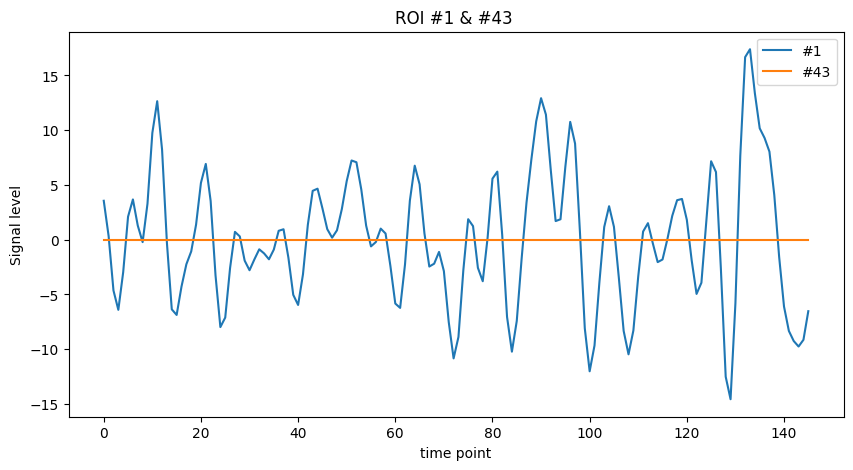

In [42]:
plot_roi(missing_ts,1,43) # visualise time series of missing roi and another non missing roi

The ROI with missing values in the correlation matrix contains 0 values  for time points in the time series data, this 0 value is likely to indicate missing values

## Search for Null values in all data
- all the dfc data needs to checked for presence of null values.
- since the null values are present in the entire time series only one time window needs to be checked
- if all values in a column of the correlation matrix has Nan values then this column represents ROI with null values

In [43]:
loaderNew = PickPickle(pickle_dir)

In [44]:
rois

['#1',
 '#2',
 '#3',
 '#4',
 '#5',
 '#6',
 '#7',
 '#8',
 '#9',
 '#10',
 '#11',
 '#12',
 '#13',
 '#14',
 '#15',
 '#16',
 '#17',
 '#18',
 '#19',
 '#20',
 '#21',
 '#22',
 '#23',
 '#24',
 '#25',
 '#26',
 '#27',
 '#28',
 '#29',
 '#30',
 '#31',
 '#32',
 '#33',
 '#34',
 '#35',
 '#36',
 '#37',
 '#38',
 '#39',
 '#40',
 '#41',
 '#42',
 '#43',
 '#44',
 '#45',
 '#46',
 '#47',
 '#48',
 '#49',
 '#50',
 '#51',
 '#52',
 '#53',
 '#54',
 '#55',
 '#56',
 '#57',
 '#58',
 '#59',
 '#60',
 '#61',
 '#62',
 '#63',
 '#64',
 '#65',
 '#66',
 '#67',
 '#68',
 '#69',
 '#70',
 '#71',
 '#72',
 '#73',
 '#74',
 '#75',
 '#76',
 '#77',
 '#78',
 '#79',
 '#80',
 '#81',
 '#82',
 '#83',
 '#84',
 '#85',
 '#86',
 '#87',
 '#88',
 '#89',
 '#90',
 '#91',
 '#92',
 '#93',
 '#94',
 '#95',
 '#96',
 '#97',
 '#98',
 '#99',
 '#100',
 '#101',
 '#102',
 '#103',
 '#104',
 '#105',
 '#106',
 '#107',
 '#108',
 '#109',
 '#110',
 '#111',
 '#112',
 '#113',
 '#114',
 '#115',
 '#116',
 '#117',
 '#118',
 '#119',
 '#120',
 '#121',
 '#122',
 '#123',
 

In [45]:
null_one = [] # roi column with 1 missing value
null_more = []# roi column with more than 1 missing value
for i,roi in enumerate(rois):
    null_num = test1[1].loc[:,rois[i]].isnull().sum()
    if null_num == 1:
        null_one.append(roi)
    else:
        null_more.append(roi)

A cursory glance at the dFC data revealed that there a Nan values in subjects in the Caltech group

In [46]:
test1 = loader.get_pickle('Caltech_0051457_dfc.pkl')

In [47]:
null_roi = {}
for i ,pickle in enumerate(all_dfc):
    dfc = loaderNew.get_pickle(pickle)
    is_null = []
    for j,roi in enumerate(rois):
        null_num = dfc[1].loc[:,rois[j]].isnull().sum()
        if null_num == 0:
            is_null.append(0)
        elif null_num == 200: # if all values of roi are Nan then append roi number to is_null
            is_null.append(roi)
    if 0 in is_null: # if there is no null values detected then continue
        continue
    else: # if a .pkl contains a roi with null values then store the roi names
        null_roi[pickle]= is_null

In [48]:
len(null_roi) # there are 48 subjects with missing values

48

In [49]:
len(null_roi)/len(pheno_df) # missing values represent 4.5% of all data, this is too much to just delete so augmentation will be required

0.0446927374301676

In [50]:
null_roi

{'Pitt_0050045_dfc.pkl': ['#52', '#176'],
 'SDSU_0050184_dfc.pkl': ['#42'],
 'SDSU_0050192_dfc.pkl': ['#32',
  '#42',
  '#49',
  '#51',
  '#71',
  '#113',
  '#124',
  '#160',
  '#169',
  '#198'],
 'SDSU_0050195_dfc.pkl': ['#12',
  '#32',
  '#39',
  '#42',
  '#53',
  '#71',
  '#124',
  '#130',
  '#198'],
 'SDSU_0050209_dfc.pkl': ['#12',
  '#15',
  '#27',
  '#32',
  '#39',
  '#41',
  '#42',
  '#43',
  '#51',
  '#53',
  '#57',
  '#71',
  '#78',
  '#87',
  '#92',
  '#101',
  '#109',
  '#110',
  '#113',
  '#124',
  '#130',
  '#139',
  '#140',
  '#160',
  '#169',
  '#181',
  '#198'],
 'SDSU_0050210_dfc.pkl': ['#27', '#198'],
 'SDSU_0050211_dfc.pkl': ['#32', '#198'],
 'SDSU_0050216_dfc.pkl': ['#12',
  '#42',
  '#43',
  '#51',
  '#57',
  '#74',
  '#78',
  '#104',
  '#109',
  '#113',
  '#124',
  '#130',
  '#139',
  '#160',
  '#169',
  '#183'],
 'Trinity_0050257_dfc.pkl': ['#32'],
 'Trinity_0050259_dfc.pkl': ['#43'],
 'Yale_0050605_dfc.pkl': ['#32',
  '#42',
  '#104',
  '#109',
  '#113',
  '#124

In [51]:
null_list = list(null_roi.keys())# list of files with null roi values

In [92]:
null_rows = pheno_df.loc[pheno_df['DFC_DATA_STORE'].isin(null_list)] # all rows in pheno_df with null .pkl files

In [93]:
null_ts = null_rows[['DFC_DATA_STORE','CC200']] #timeseries and .pkl files for null values

In [94]:
null_ts.reset_index(inplace =True,drop = True) # reset index

In [95]:
null_ts

,DFC_DATA_STORE,CC200
0,Pitt_0050045_dfc.pkl,Pitt_0050045_rois_cc200.1D
1,SDSU_0050184_dfc.pkl,SDSU_0050184_rois_cc200.1D
2,SDSU_0050192_dfc.pkl,SDSU_0050192_rois_cc200.1D
3,SDSU_0050195_dfc.pkl,SDSU_0050195_rois_cc200.1D
4,SDSU_0050209_dfc.pkl,SDSU_0050209_rois_cc200.1D
5,SDSU_0050210_dfc.pkl,SDSU_0050210_rois_cc200.1D
6,SDSU_0050211_dfc.pkl,SDSU_0050211_rois_cc200.1D
7,SDSU_0050216_dfc.pkl,SDSU_0050216_rois_cc200.1D
8,Trinity_0050257_dfc.pkl,Trinity_0050257_rois_cc200.1D
9,Trinity_0050259_dfc.pkl,Trinity_0050259_rois_cc200.1D


In [56]:
missing_ts1 = roi_get.fetch_roi_avg_ts(null_ts.loc[0,'CC200'])

In [57]:
missing_ts1

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,#191,#192,#193,#194,#195,#196,#197,#198,#199,#200\r
0,-5.098457,3.303856,-14.490761,3.275247,1.402026,-2.616367,4.408323,-3.663762,0.729199,-2.288702,...,4.759427,0.189392,-12.248494,6.240186,3.114559,10.540835,-1.696346,-0.438769,17.839118,-6.786234
1,-6.042293,-2.021787,-20.852084,-4.451602,6.987915,4.349821,12.109627,-1.110308,-0.208897,-6.071699,...,12.373349,2.119557,-5.484328,4.442127,7.009160,14.694322,-3.676412,2.178650,14.009755,-8.279371
2,-5.625985,-9.120737,-20.836527,-12.428690,9.738691,12.297411,16.973316,6.768377,-1.228678,-7.435407,...,19.133605,3.277829,3.138734,0.839279,11.044431,12.638503,-6.980092,6.085007,4.409849,-8.220374
3,-5.528972,-15.276312,-14.729185,-16.994215,7.435225,15.760925,16.005363,17.009606,-2.461568,-5.486019,...,20.413300,2.653323,8.284760,-3.819520,12.500289,3.900669,-11.156391,9.752737,-6.688404,-7.683354
4,-7.353960,-18.147472,-6.764729,-16.742057,0.735598,10.587245,10.089874,23.911041,-4.222795,-1.359234,...,13.664494,0.390357,7.052030,-8.316753,9.390947,-8.488548,-14.925056,11.312873,-14.513787,-7.982428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,-1.917227,28.577748,10.831488,-5.659968,-0.813247,-20.050932,14.635724,-17.687761,-2.954397,-3.678988,...,-2.663568,4.160128,10.483397,13.901987,5.193343,-5.720442,-11.206888,5.598039,10.639066,-27.707093
192,0.640986,12.779397,20.840134,2.009321,6.579918,-9.166597,13.420244,-21.074615,3.691257,-1.086608,...,10.431144,3.605178,23.536366,24.690786,12.320717,-8.559222,-6.896887,2.847556,2.660504,-16.101903
193,1.899826,-2.549563,25.584118,11.008234,12.476661,1.695483,7.163878,-20.249446,9.132592,1.557954,...,17.631993,0.892692,26.930509,27.075134,13.405003,-11.189073,-5.493693,0.345075,-6.646351,-1.964198
194,1.061723,-11.733835,22.312095,16.910808,14.224362,6.697251,-0.738711,-15.759127,10.617241,2.750339,...,16.641552,-2.447929,20.697173,20.663489,8.516078,-11.240116,-7.796206,-1.085316,-14.097391,8.379942


In [58]:
null_roi[null_ts.loc[0,'DFC_DATA_STORE']]

['#52', '#176']

In [59]:
null_ts_values = []
for i in range(len(null_ts)):
    time = roi_get.fetch_roi_avg_ts(null_ts.loc[i,'CC200'])
    roi = null_roi[null_ts.loc[i,'DFC_DATA_STORE']]
    for r in roi:
        ts_vals = time.loc[:,r].values
    null_ts_values.append(ts_vals.flatten())

In [60]:
len(null_ts_values)

48

In [64]:
null_ts_values[1]

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

If there is a row of Nan values in the pairwise correlation matrices, these row corresponds to  ROIs in the time series data containing only 0 values. These ROIs are likely to contain null values as well. Additionally, these 0 values are likely to have influenced the pairwise pearson correlation calculations for all ROIs in these 48 subjects therefore the null values in the timeseries data will have to be augmented first, and then the dFC calculations carried out again.

In order to prevent data leakage the training and test

In [65]:
null_roi

{'Pitt_0050045_dfc.pkl': ['#52', '#176'],
 'SDSU_0050184_dfc.pkl': ['#42'],
 'SDSU_0050192_dfc.pkl': ['#32',
  '#42',
  '#49',
  '#51',
  '#71',
  '#113',
  '#124',
  '#160',
  '#169',
  '#198'],
 'SDSU_0050195_dfc.pkl': ['#12',
  '#32',
  '#39',
  '#42',
  '#53',
  '#71',
  '#124',
  '#130',
  '#198'],
 'SDSU_0050209_dfc.pkl': ['#12',
  '#15',
  '#27',
  '#32',
  '#39',
  '#41',
  '#42',
  '#43',
  '#51',
  '#53',
  '#57',
  '#71',
  '#78',
  '#87',
  '#92',
  '#101',
  '#109',
  '#110',
  '#113',
  '#124',
  '#130',
  '#139',
  '#140',
  '#160',
  '#169',
  '#181',
  '#198'],
 'SDSU_0050210_dfc.pkl': ['#27', '#198'],
 'SDSU_0050211_dfc.pkl': ['#32', '#198'],
 'SDSU_0050216_dfc.pkl': ['#12',
  '#42',
  '#43',
  '#51',
  '#57',
  '#74',
  '#78',
  '#104',
  '#109',
  '#113',
  '#124',
  '#130',
  '#139',
  '#160',
  '#169',
  '#183'],
 'Trinity_0050257_dfc.pkl': ['#32'],
 'Trinity_0050259_dfc.pkl': ['#43'],
 'Yale_0050605_dfc.pkl': ['#32',
  '#42',
  '#104',
  '#109',
  '#113',
  '#124

In [98]:
null_ts['MISSING_ROI'] =np.zeros(len(null_ts)) # add column Missing_roi to imput missing roi region lists

/var/folders/0k/w62sf0c17hs15h730mmdkmj40000gn/T/ipykernel_696/1578741013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_ts['MISSING_ROI'] =np.zeros(len(null_ts))


In [100]:
for i, (k, v) in enumerate(null_roi.items()):
    entry = pd.Series(v)
    if null_ts.loc[i,'DFC_DATA_STORE']== k:
        null_ts.at[i,'MISSING_ROI'] = entry

In [101]:
null_ts.head()

,DFC_DATA_STORE,CC200,MISSING_ROI
0,Pitt_0050045_dfc.pkl,Pitt_0050045_rois_cc200.1D,"[#52, #176]"
1,SDSU_0050184_dfc.pkl,SDSU_0050184_rois_cc200.1D,[#42]
2,SDSU_0050192_dfc.pkl,SDSU_0050192_rois_cc200.1D,"[#32, #42, #49, #51, #71, #113, #124, #160, #1..."
3,SDSU_0050195_dfc.pkl,SDSU_0050195_rois_cc200.1D,"[#12, #32, #39, #42, #53, #71, #124, #130, #198]"
4,SDSU_0050209_dfc.pkl,SDSU_0050209_rois_cc200.1D,"[#12, #15, #27, #32, #39, #41, #42, #43, #51, ..."


In [102]:
null_path = os.path.join(pheno_dir, 'null_df.csv')

'/Users/admin/Documents/Project/phenotype_files/null_df.csv'

In [103]:
null_ts.to_csv(null_path, index= False)

In [138]:
pickle_dir70 = os.path.join(parent_dir, 'dfc_cc200_70') # subdirectory containing dfc data

In [139]:
loader70 = PickPickle(pickle_dir70)

In [140]:
test1 = loader70.get_pickle('Caltech_0051457_dfc.pkl') # import pkl file where missing values were noticed

In [142]:
len(test1)

42

In [143]:
y

NameError: name 'y' is not defined

# Concat

In [45]:
parent_dir = os.path.dirname(os.getcwd())
pheno_dir = os.path.join(parent_dir, 'phenotype_files')

In [17]:
pickle_dir70 = os.path.join(parent_dir, 'dfc_cc200_70')

In [56]:
class Joiner:
    def __init__(self, pickle_dir, concat_dir,df):
        self.pickle_dir = pickle_dir
        self.pickle_files = list(df.DFC_DATA_STORE.values)
        self.pickle_paths = [os.path.join(self.pickle_dir, dict_name) for dict_name in self.pickle_files]
        self.concat_dir = concat_dir
        os.mkdir(concat_dir)

    def join_all(self):
        for i, path in enumerate(self.pickle_paths):
            with open(path, 'rb') as f:
                dfc = pickle.load(f)

            joined = pd.concat([dfc[i] for i in list(dfc.keys()) ]).to_numpy()

            dump_path = os.path.join(self.concat_dir,self.pickle_files[i])

            with open(dump_path, 'wb') as d:
                pickle.dump(joined, d, protocol=pickle.HIGHEST_PROTOCOL)

        print("All dfc concatenated and stored")


In [59]:
pieces = Joiner(pickle_dir70, con, df)

In [62]:
pieces.join_all()

All dfc concatenated and stored


## Using time windows for data augmentation
- using time windows as data augmentation

In [86]:
nn_df = pd.read_csv('/Users/admin/Documents/MscProject/phenotype_files/pheno_nn.csv')

In [98]:
class Augmentor:
    '''
    Breaks apart time windows in one dfc dictionary to separate np arrays for data augmentation
    '''
    def __init__(self, pheno_df, data_dir,dump_dir):
        self.df= pheno_df
        self.data_dir = data_dir
        self.dump_dir = dump_dir
        os.mkdir(dump_dir)
        self.source_paths = [os.path.join(data_dir, p) for p in pheno_df.DFC_DATA_STORE]
        self.file_ids = pheno_df.FILE_ID # file ids

    def dump_path(self,file_id,window):
        dump_file = file_id + f'_{window}.pkl' #add window number designation for unique file id
        return os.path.join(self.dump_dir, dump_file) # save path for each array

    def breaker(self):

        for i, path in enumerate(self.source_paths):
            with open(path, 'rb') as f:
                dfc_dict = pickle.load(f) # load dict
            for win in range(1, 43):
                data = dfc_dict[win].to_numpy(dtype = np.float32) #covert to float32 for pytorch
                path = self.dump_path(self.file_ids[i],win) # make path to array pickle
                with open(path, 'wb') as handle:
                    pickle.dump(data,handle, protocol= pickle.HIGHEST_PROTOCOL) # save array as pickle

        print("all dfc dicts broken and saved as separate np arrays")




In [101]:
disassemble = Augmentor(nn_df, pickle_dir70,'/Users/admin/Documents/MscProject/augmented_dataset' )

In [102]:
disassemble.breaker()

all dfc dicts broken and saved as separate np arrays


# changing train and test annotation file- bivariate data

In [155]:
pheno_dir = '/Users/admin/Documents/MscProject/phenotype_files'

In [142]:
train_path = os.path.join(pheno_dir, 'train_nn.csv')
test_path = os.path.join(pheno_dir, 'test_nn.csv')

In [143]:
train_w = pd.read_csv(train_path)
test_w = pd.read_csv(test_path)

In [144]:
train_w.head()

,SUB_ID,FILE_ID,TARGET
0,50985,NYU_0050985,1
1,50380,UM_1_0050380,0
2,50826,KKI_0050826,1
3,50663,CMU_a_0050663,0
4,51015,NYU_0051015,1


In [4]:
def extender(df):
    file_ids = df.FILE_ID
    files = []# store <file_id>_<window_num>.pkl lists
    labels = [] # store label for each file
    for i,file in enumerate(file_ids):
        auged = [file + f'_{w}.pkl' for w in range(1,43)] # add _<window_num>.pkl extension to file id
        label = [df.TARGET[i]]* 42 # make label list of length 42 as label for each seperate array
        files.extend(auged) # extend files with augmented file ids
        labels.extend(label)

    return pd.DataFrame({'FILE_ID': files, 'TARGET': labels}) # make pandas datafram and return

In [152]:
train_aug = extender(train_w)
test_aug = extender(test_w)

In [157]:
train_aug_path = os.path.join(pheno_dir,'train_aug.csv')
test_aug_path = os.path.join(pheno_dir,'test_aug.csv')

In [158]:
train_aug.to_csv(train_aug_path, index= False)
test_aug.to_csv(test_aug_path, index= False)

# changing train and test annotation file- multi-variate data

In [3]:
pheno_dir = '/Users/admin/Documents/MscProject/phenotype_files'
train_mc_path = os.path.join(pheno_dir, 'mc_train.csv')
test_mc_path = os.path.join(pheno_dir, 'mc_test.csv')
train_mc = pd.read_csv(train_mc_path)
test_mc = pd.read_csv(test_mc_path)

In [7]:
train_mc_aug = extender(train_mc)
test_mc_aug = extender(test_mc)

In [8]:
train_aug_mc_path = os.path.join(pheno_dir,'mc_train_aug.csv')
test_aug_mc_path = os.path.join(pheno_dir,'mc_test_aug.csv')

In [9]:
train_mc_aug.to_csv(train_aug_mc_path , index= False)
test_mc_aug.to_csv(test_aug_mc_path, index= False)